# Indentify factors that may indicate customers are unlikely to pay their loan

Let's bring in the data set and split it up into three groups - Charged off loans, late payment loans, other loans.  We can then start looking for patterns.

In [1]:
import db_utils as dbu
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('loan_payments_clean.csv')

In [3]:
charged_off_loans = df[(df['loan_status'] == 'Charged Off')]
late_loans = df[(df['loan_status'] == 'Late (31-120 days)') | (df['loan_status'] == 'Late (16-30 days)')]
good_loans = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Current')]

Let's plot some pie charts for categorical data that might indicate customers are unlikely to pay their loans.  Let's first look at grade, purpose and homeownership.

In [4]:
co_plot = dbu.Plotter(charged_off_loans)
ll_plot = dbu.Plotter(late_loans)
gl_plot = dbu.Plotter(good_loans)

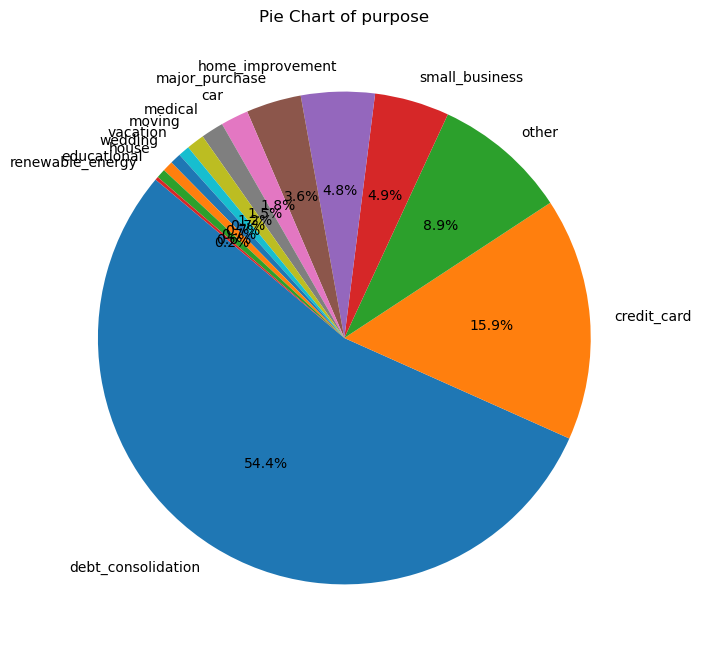

In [5]:
co_plot.plot_pie_chart('purpose')

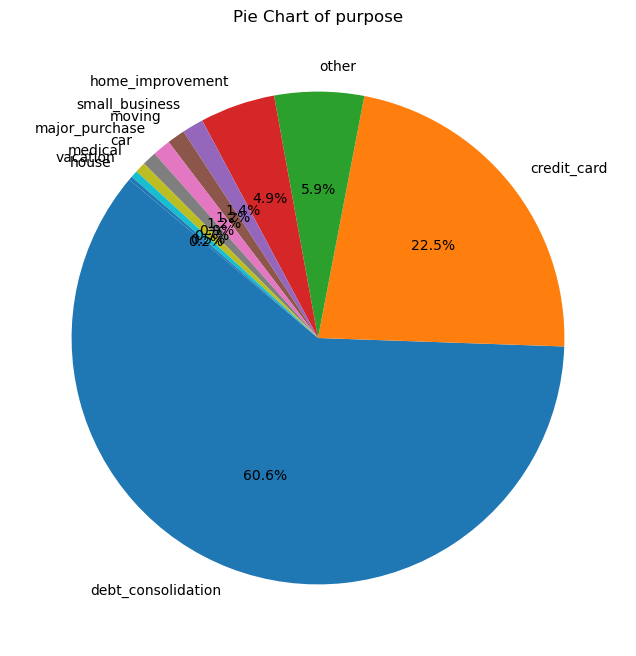

In [6]:
ll_plot.plot_pie_chart('purpose')

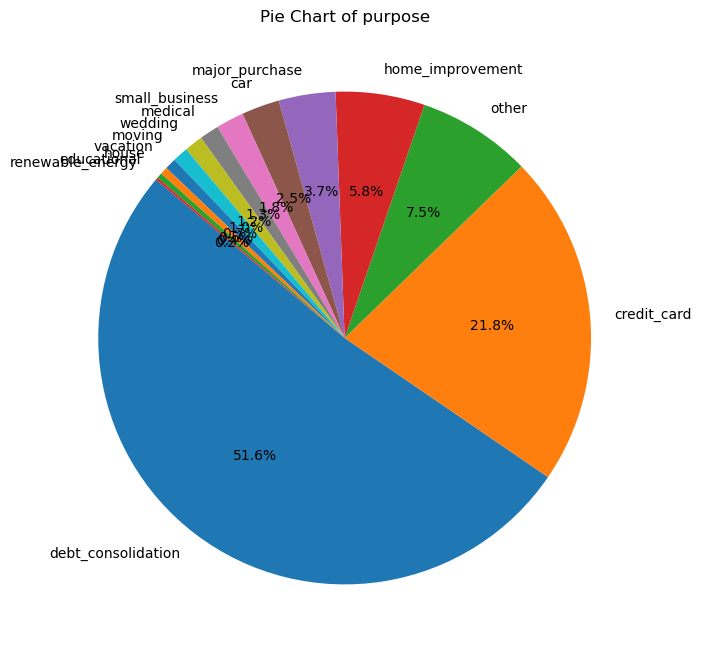

In [7]:
gl_plot.plot_pie_chart('purpose')

The distributions of the purpose of the loans all appear similar.  With the only obvious difference being a slightly higher of charged of and late loans being debt consolidation loans than the 'good' loans.   This could suggest that debt colsolidation loans carry an increased risk.

Let's have a look at the pie charts for homeownership:

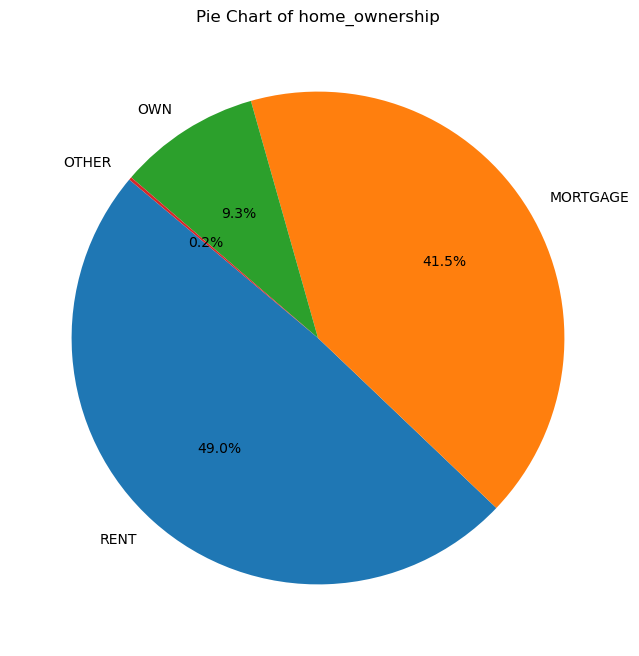

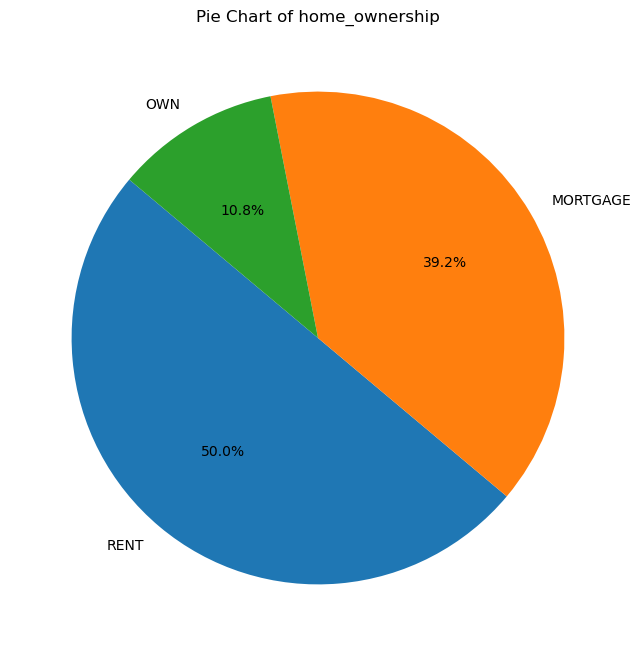

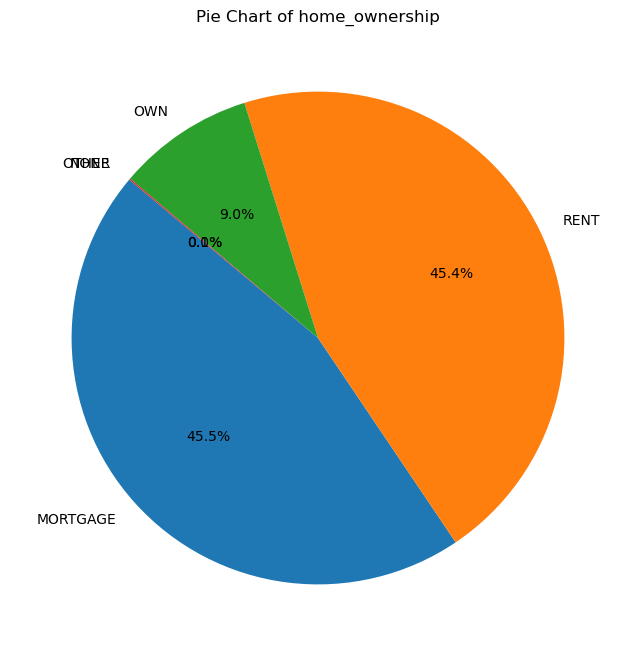

In [8]:
co_plot.plot_pie_chart('home_ownership')
ll_plot.plot_pie_chart('home_ownership')
gl_plot.plot_pie_chart('home_ownership')


The 'good' loans have a slight higher proportion of mortgages and slightly lower proportion of rental suggesting that customers with a mortgage might be slightly lower risk.

To look at grade, it makes sense to convert the grade to a number to allow for better statisical analysis.  We'll look at the pie charts anyway just incase something stands out:

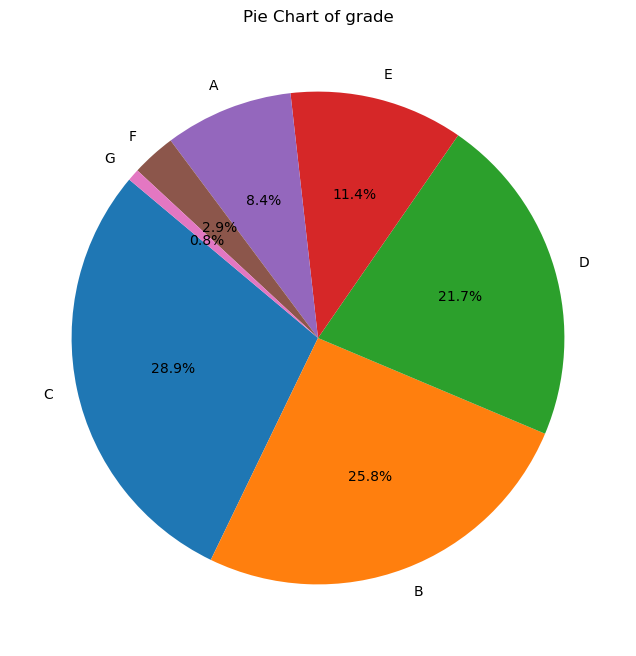

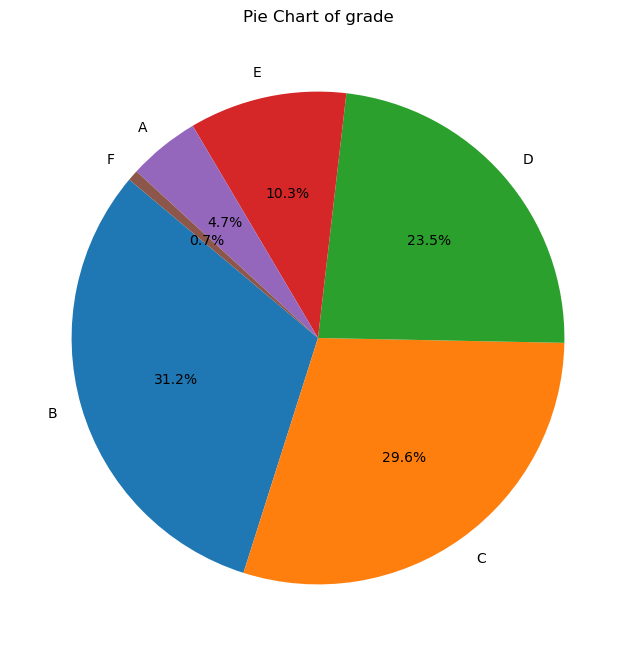

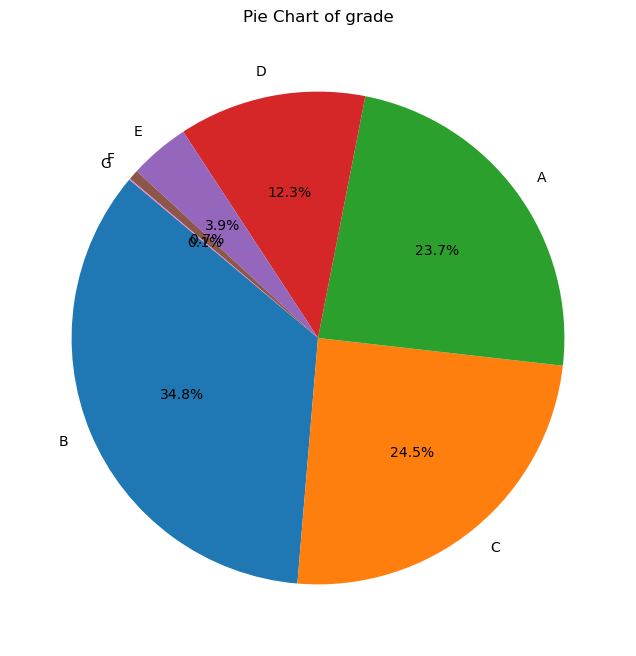

In [9]:
co_plot.plot_pie_chart('grade')
ll_plot.plot_pie_chart('grade')
gl_plot.plot_pie_chart('grade')

The 'good' loans appear to have higher proportion of grades A and B.  The late and charged off loans have much higher proportion of grades D and E.  The charged off loans have much higher proportion of Grade F and G loans.  This suggests that Grades F and G carry a high risk.  This pattern would appear to make sense as the loan grades are likely to be associated with risk.

This pie chart analysis seems useful so lets write a quick function to plot all three charts for a certain column.

In [10]:
def three_pie(column):
    # Define the categories and colours
    categories = sorted(set(co_plot.data_frame[column].unique()) | 
                        set(ll_plot.data_frame[column].unique()) | 
                        set(gl_plot.data_frame[column].unique()))
    
    colours = plt.cm.tab20.colors[:len(categories)]  # Use a colormap to get a list of colours
    
    co_plot.plot_pie_chart(column, categories, colours)
    ll_plot.plot_pie_chart(column, categories, colours)
    gl_plot.plot_pie_chart(column, categories, colours)

Let's look at some other columns:

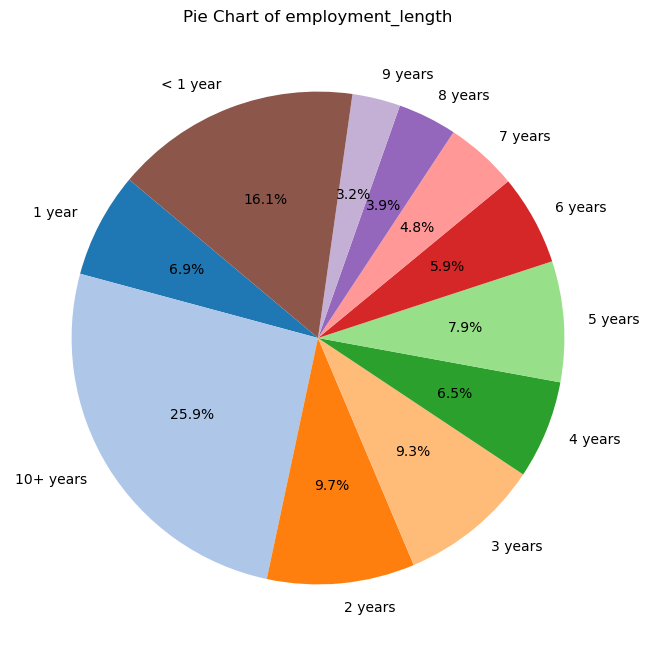

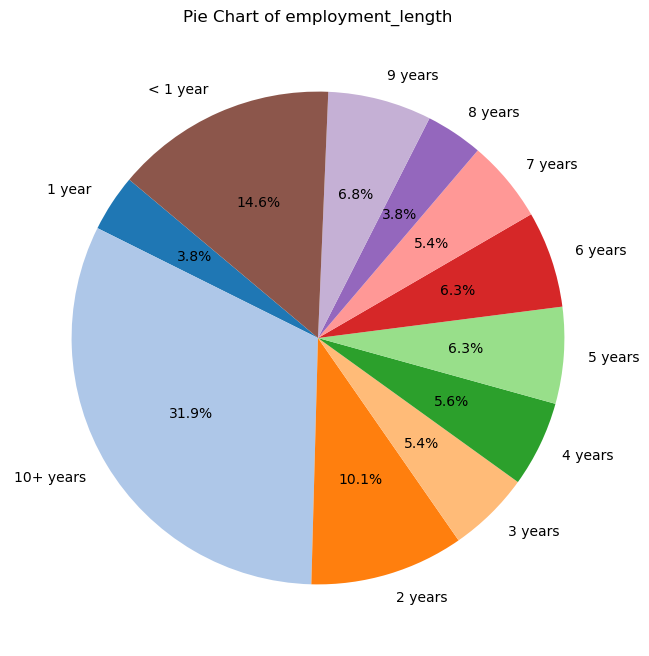

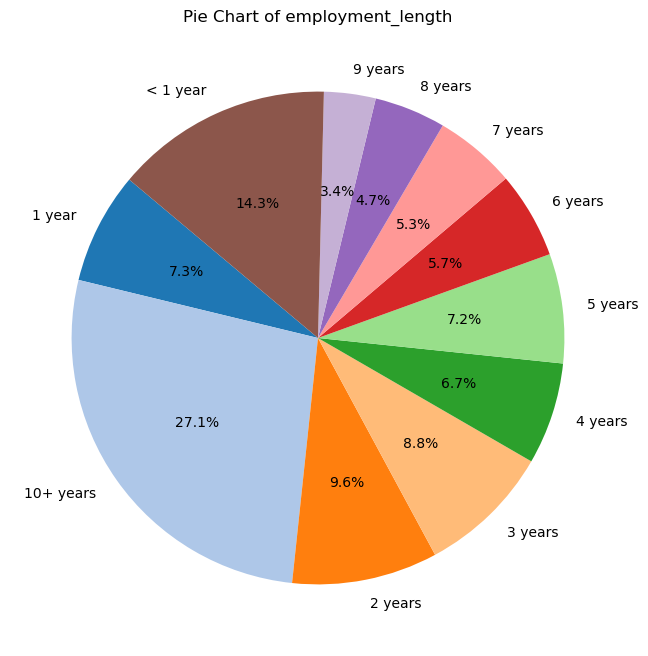

In [11]:
three_pie('employment_length')

There isn't anything obvious that stands out from the employment length.

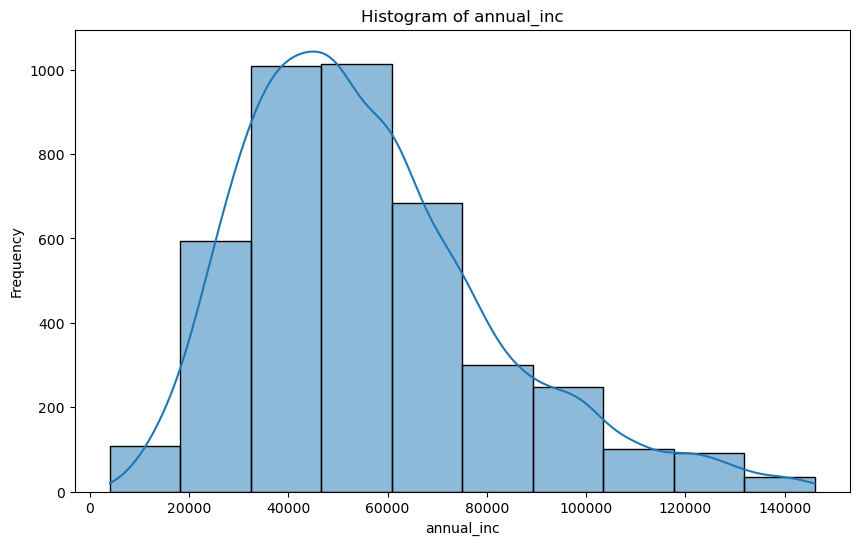

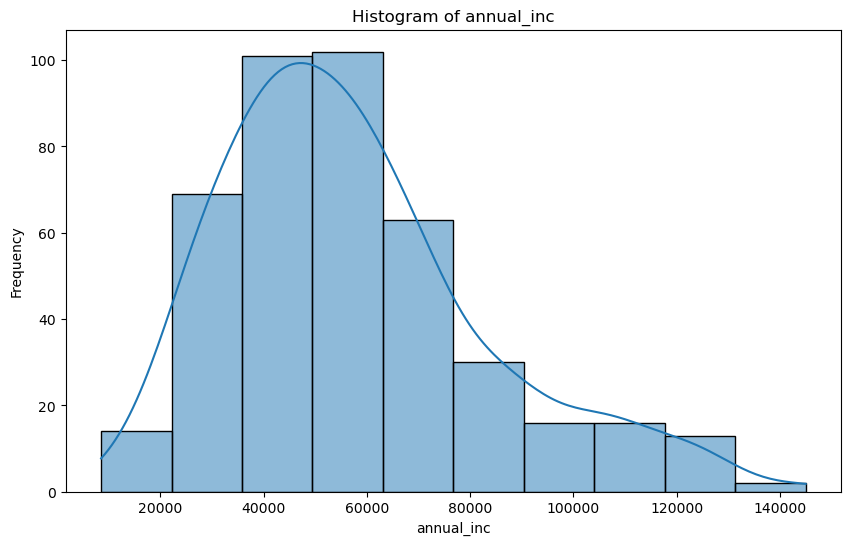

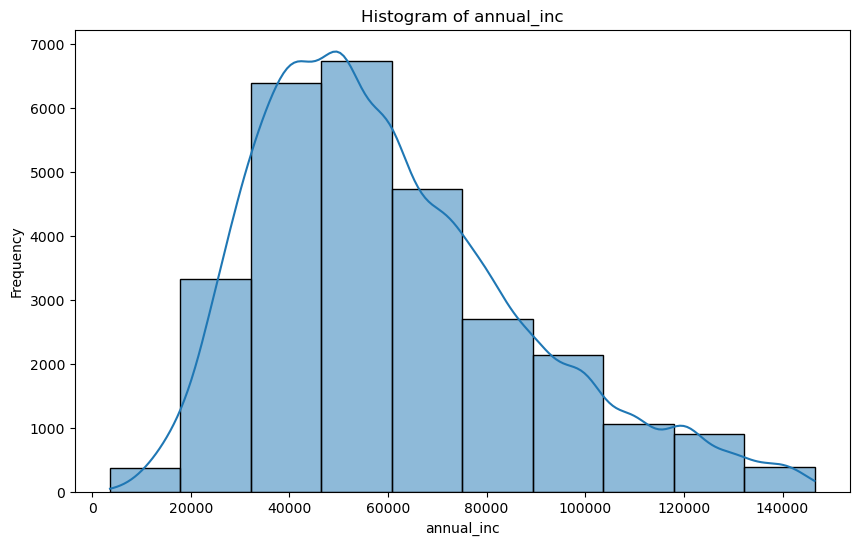

In [12]:
co_plot.plot_histogram('annual_inc')
ll_plot.plot_histogram('annual_inc')
gl_plot.plot_histogram('annual_inc')

In [13]:
coinf = dbu.DataFrameInfo(charged_off_loans)
llinf = dbu.DataFrameInfo(late_loans)
glinf = dbu.DataFrameInfo(good_loans)

In [14]:
coinf.extract_statistics()
llinf.extract_statistics()
glinf.extract_statistics()

Statistics:

Numerical Columns:
Median:
 Unnamed: 0                            2.000150e+04
id                                    1.065354e+06
member_id                             1.298570e+06
loan_amount                           1.000000e+04
funded_amount                         1.000000e+04
funded_amount_inv                     1.000000e+04
int_rate                              1.398000e+01
instalment                            3.165100e+02
annual_inc                            5.100000e+04
dti                                   1.604000e+01
delinq_2yrs                           0.000000e+00
inq_last_6mths                        1.000000e+00
open_accounts                         9.000000e+00
total_accounts                        2.000000e+01
out_prncp                             0.000000e+00
total_payment                         4.596210e+03
total_rec_int                         1.243155e+03
total_rec_late_fee                    0.000000e+00
recoveries                            1.4

The medians of annual income of the charged off loans, late loans and good loans are 51000, 54000 and 55000 respectively.  This could suggest that a higher annual income relates to a lower risk in customers.  What might be more interesting is looking at the loan amount as a proportion of the income.

We can also look at means for a couple of other columns:

dti: 
    co 1.6,
    ll 1.8,
    gl 1.6.

delinq_2yrs:
    co 2.16,
    ll 3.05,
    gl 2.23.

It might be more interesting to see these plotted against the loan status.  


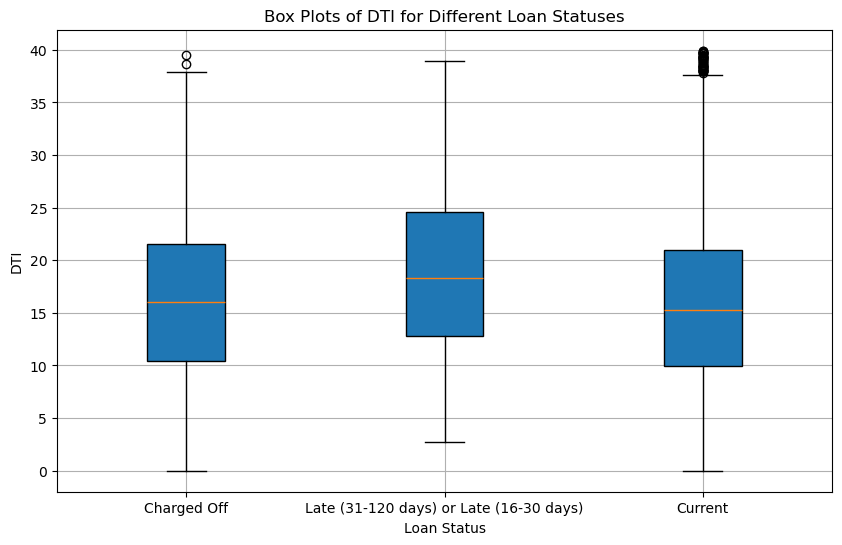

In [15]:
dti_plot = [charged_off_loans['dti'], late_loans['dti'], good_loans['dti']]
plt.figure(figsize=(10, 6))
plt.boxplot(dti_plot, patch_artist=True, labels=['Charged Off', 'Late (31-120 days) or Late (16-30 days)', 'Current'])
plt.title('Box Plots of DTI for Different Loan Statuses')
plt.xlabel('Loan Status')
plt.ylabel('DTI')
plt.grid(True)
plt.show()

This is a nice plot looking at distributions of a numerical value for the three subsets off the dataset.  I'll turn it into a function so we can see the result for other columns:

In [16]:

def three_box_plots(column):
    """
    Plot box plots of the specified column for different loan statuses.
    
    :param df: pandas DataFrame containing the data
    :param column: Column name to plot
    """
    data_plot = [charged_off_loans[column], late_loans[column], good_loans[column]]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data_plot, patch_artist=True, labels=['Charged Off', 'Late (31-120 days) or Late (16-30 days)', 'Current'])
    plt.title(f'Box Plots of {column} for Different Loan Statuses')
    plt.xlabel('Loan Status')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

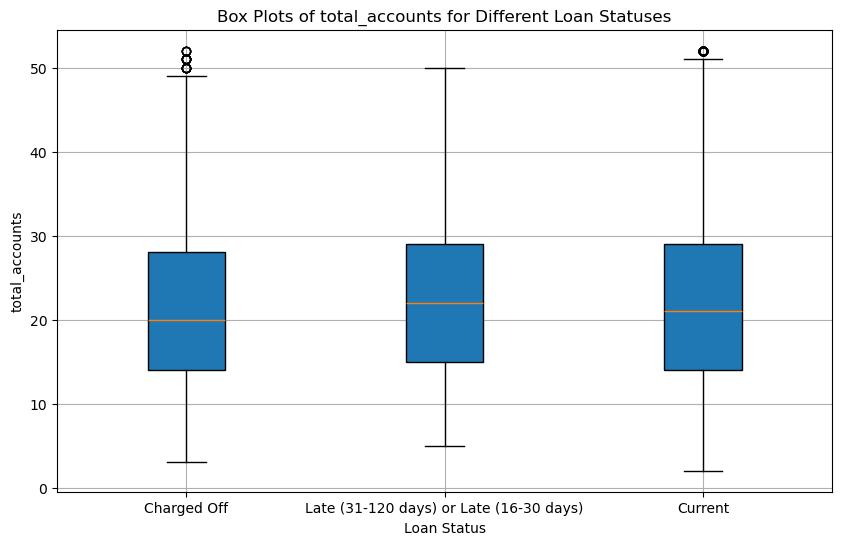

In [17]:
three_box_plots('total_accounts')

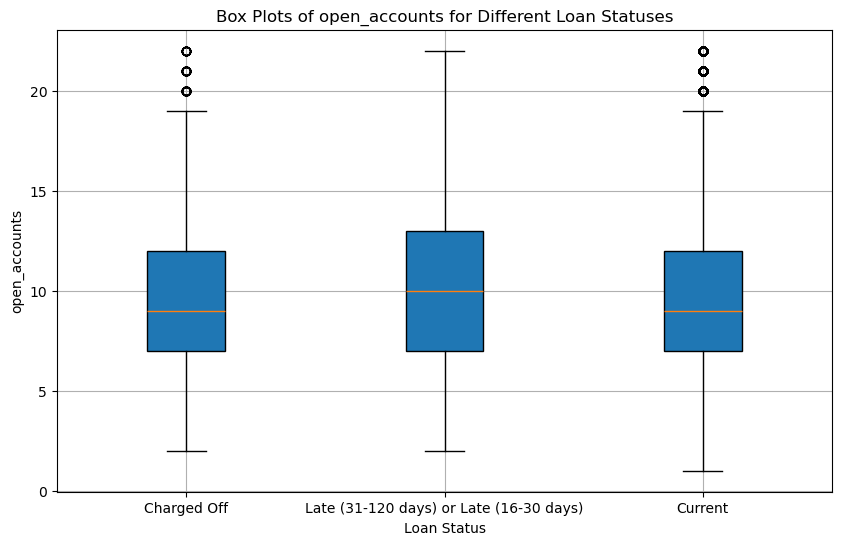

In [18]:
three_box_plots('open_accounts')

Boths of the plots about the number of customer accounts show a slightly higher median for the late loans which could suggest that more customer accounts indicates a higher chance of late payments.

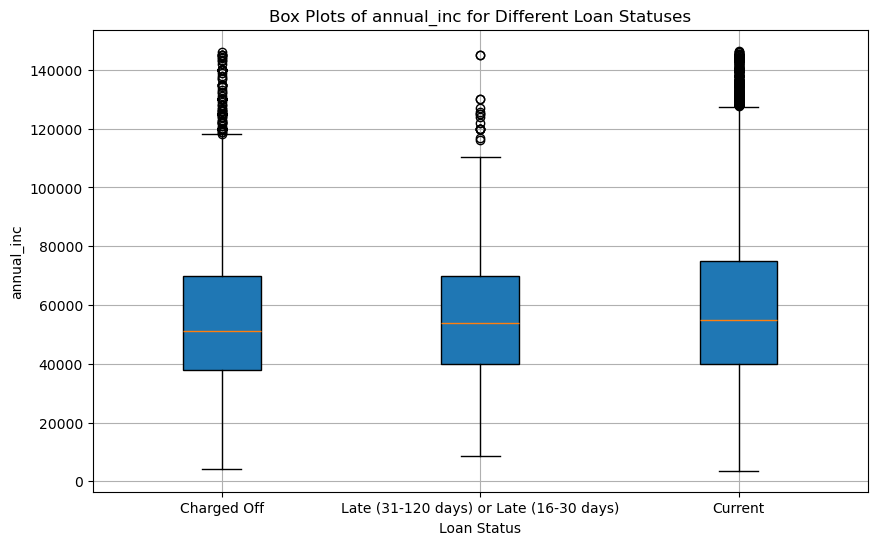

In [19]:
three_box_plots('annual_inc')

Looking at the income again, the same pattern of slightly increased averages appears.

Let's look at the loan grades again but apply a map to turn them into numbers:

In [20]:
df['sub_grade'].value_counts()

sub_grade
B3    2502
B4    2427
B2    2247
B5    2113
B1    2097
C1    2060
A5    2052
C2    1966
A4    1917
C3    1805
C4    1519
C5    1343
A3    1299
D1    1137
D2    1115
A2    1103
D3     992
A1     857
D4     856
D5     724
E1     486
E2     458
E3     367
E4     297
E5     278
F1     190
F2      68
F3      52
F4      47
G1      35
F5      30
G2      29
G5      19
G3      15
G4      15
Name: count, dtype: int64

We'll create a dictionary to map the grade into numbers:

In [21]:
grade_dict = {
    'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5,
    'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10,
    'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15,
    'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20,
    'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25,
    'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30,
    'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35
}

In [22]:
df['sub_grade_num'] = df['sub_grade'].map(grade_dict)

Let's just partition the data frame again with this new column added:

In [23]:
charged_off_loans = df[(df['loan_status'] == 'Charged Off')]
late_loans = df[(df['loan_status'] == 'Late (31-120 days)') | (df['loan_status'] == 'Late (16-30 days)')]
good_loans = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Current')]

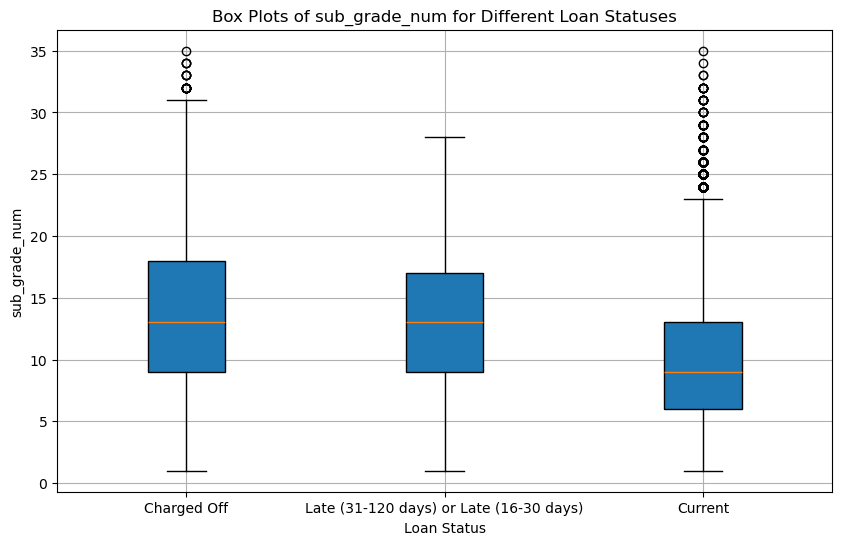

In [24]:
three_box_plots('sub_grade_num')

The pattern we observed earlier is show clearly here again.

In [28]:
upper_quartile_lv = df['loan_amount'].quantile(0.75)
median_lv = df['loan_amount'].quantile(0.5)
lower_quartile_lv = df['loan_amount'].quantile(0.25)

In [30]:
high_value_loans = df[(df['loan_amount'] > upper_quartile_lv)]
middle_50_value_loans = df[(df['loan_amount'] >= lower_quartile_lv) & (df['loan_amount'] <= upper_quartile_lv)]
low_value_loans = df[(df['loan_amount'] < lower_quartile_lv)]

In [31]:
high_value_loans['loan_status'].value_counts(normalize=True)

loan_status
Current                                                0.554722
Fully Paid                                             0.239848
Charged Off                                            0.166964
Late (31-120 days)                                     0.014648
Does not meet the credit policy. Status:Fully Paid     0.007979
Does not meet the credit policy. Status:Charged Off    0.006193
In Grace Period                                        0.005955
Late (16-30 days)                                      0.002620
Default                                                0.001072
Name: proportion, dtype: float64

In [32]:
middle_50_value_loans['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid                                             0.481703
Current                                                0.367651
Charged Off                                            0.106198
Does not meet the credit policy. Status:Fully Paid     0.018610
Late (31-120 days)                                     0.010529
Does not meet the credit policy. Status:Charged Off    0.007228
In Grace Period                                        0.005520
Late (16-30 days)                                      0.001480
Default                                                0.001081
Name: proportion, dtype: float64

In [33]:
low_value_loans['loan_status'].value_counts(normalize=True)

loan_status
Fully Paid                                             0.588958
Current                                                0.243303
Charged Off                                            0.106679
Does not meet the credit policy. Status:Fully Paid     0.037548
Does not meet the credit policy. Status:Charged Off    0.012750
Late (31-120 days)                                     0.006083
Late (16-30 days)                                      0.002106
In Grace Period                                        0.001755
Default                                                0.000819
Name: proportion, dtype: float64

In [40]:


def plot_three_pie_charts(column, dataset1, dataset2, dataset3):
    """
    Plots pie charts for the distribution of a specified column in three datasets.
    
    :param column: The column to plot
    :param dataset1: The first dataset (pandas DataFrame)
    :param dataset2: The second dataset (pandas DataFrame)
    :param dataset3: The third dataset (pandas DataFrame)
    """
    # Get unique values across all datasets
    unique_values = pd.concat([dataset1[column], dataset2[column], dataset3[column]]).unique()
    unique_values.sort()

    # Create color map
    colors = plt.cm.get_cmap('tab20', len(unique_values))
    color_dict = {value: colors(i) for i, value in enumerate(unique_values)}

    # Define function to plot a single pie chart
    def plot_pie_chart(data, ax, title):
        value_counts = data[column].value_counts().sort_index()
        value_counts = value_counts.reindex(unique_values, fill_value=0)
        wedges, texts, autotexts = ax.pie(value_counts, colors=[color_dict[key] for key in value_counts.index], autopct='%1.1f%%', textprops=dict(color="w"))

        ax.set_title(title, fontsize=14)
        ax.legend(wedges, value_counts.index, title=column, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
        
        # Increase the size of the text
        plt.setp(autotexts, size=10, weight="bold")
        plt.setp(texts, size=12)

    # Create subplots with increased figure size
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    # Plot pie charts
    plot_pie_chart(dataset1, axes[0], 'Dataset 1')
    plot_pie_chart(dataset2, axes[1], 'Dataset 2')
    plot_pie_chart(dataset3, axes[2], 'Dataset 3')

    # Show the plot
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_23954/770278801.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_values))


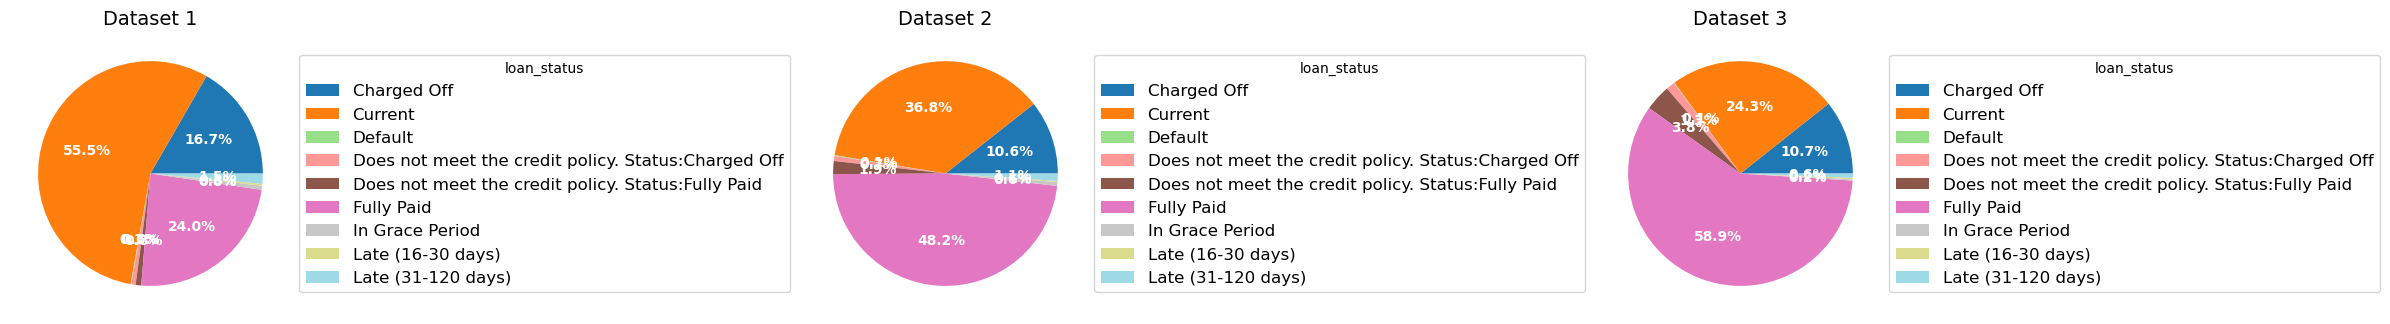

In [41]:
plot_three_pie_charts('loan_status', high_value_loans, middle_50_value_loans, low_value_loans)

By splitting the data this way, we can see that the proportion of higher value loans that have been charged off is higher than the proportion of the other value loans.  This suggests that a high loan amount (higher than quartile 3) could indicate higher risk.

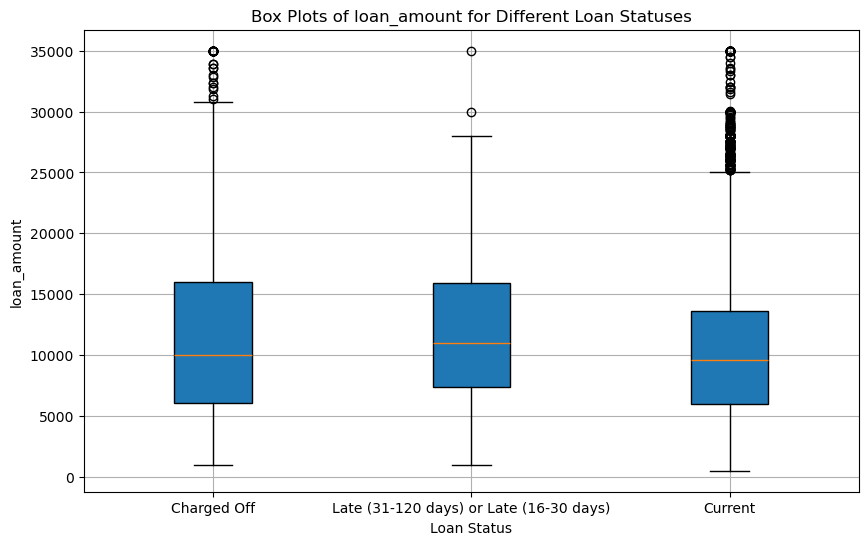

In [43]:
three_box_plots('loan_amount')